In [1]:
import pandas as pd
import numpy as np
import psycopg2
from analysys_funcs import *
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
import optuna
import math
from sklearn.preprocessing import RobustScaler, MinMaxScaler

c:\Users\eliza\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


"Сырые" данные о квартирах хранятся в базе данных. Для их получения необходимо установить соединение с ней.

In [56]:
conn = psycopg2.connect(host='ep-black-pond-a2ydwdvs.eu-central-1.aws.neon.tech', database='Akademdb', user='Elizar54', password='XUpC1QOnGvA4')
cur = conn.cursor()

Загружаем данные из базы данных.

In [57]:

df = pd.read_sql_query('select distinct * from flats_new', conn)

C:\Users\eliza\AppData\Local\Temp\ipykernel_25164\1440463453.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query('select distinct * from flats_new', conn)


Осуществляем общую предобработку данных. В предварительную предобработку вошли следующие составляющие:
1. Приведение информации о расстоянии до метро, цене, площади квартиры, количестве туалетов, лифтов, балконах и лоджиях в корректный формат для дальнейшей работы;
2. Удаление колонок, состоящих по большей части из пропущенных значений (warning, trash, barriers), не несущих какой-либо важной информации (id), содержащих большое количество пропущенных значений (decor, year) или одинаковые для всех наблюдений значения (rented).
3. Удаление дупликатов.
4. Заполнение пропусков. Пропуски в колонках с численными значениями были заполнены средним или средним по группе (расстояние до метро в минутах), для категориальных признаков использовалась мода.
5. Удаление наблюдений, в которых отсутствовала информация об общей жилой площади, жилой площади и площади кухни.
6. Удаление наблюдений с некорректным названием района.

In [58]:

df['metro'] = df['metro'].apply(metro_distance)
df['price'] = df['price'].apply(price_corr)
df.drop(['warning', 'trash'], inplace=True, axis=1)
df.drop_duplicates(inplace=True)

for column in ['total_square', 'living_sq', 'kitchen_sq']:
    df[column] = df[column].apply(square_corr)

df['floor'] = df['floor'].apply(floor_corr)
df['ceil_height'] = df['ceil_height'].apply(lambda x: float(x.replace(',', '.').split()[0]) if x != 'None' else np.nan)
df['entrance'] = df['entrance'].apply(lambda x: int(x) if x != 'None' else np.nan)
df['barriers'] = df['barriers'].apply(lambda x: x if x != 'Нет информации' else df['barriers'].mode()[0])
df['district'] = df['address'].apply(lambda x: x.split()[4] if len(x) >=4 else x)
df = df.replace('None', np.nan)
df.drop('address', inplace=True, axis=1)
df['barriers'].fillna(df['barriers'].mode()[0], inplace=True)
df['toilets'].fillna(df['toilets'].mode()[0], inplace=True)
df['warm'].fillna(df['warm'].mode()[0], inplace=True)
df['home_type'].fillna(df['home_type'].mode()[0], inplace=True)
df['ceil_height'] = df['ceil_height'].apply(lambda x: x/10 if x > 10 else x)
df['big_elevs'] = df['elevators'].apply(big_elevators)
df['little_elevs'] = df['elevators'].apply(lit_elevators)
df['single_toilet'] = df['toilets'].apply(toilet_single)
df['connect_toilet'] = df['toilets'].apply(toilet_not_sngl)
df['balcony_only'] = df['balcony'].apply(balcony)
df['lodgia'] = df['balcony'].apply(lodgia)

df = df[df['district'].isin(['Советский', 'Центральный', 'Октябрьский', 'Кировский', \
                              'Ленинский', 'Заельцовский', 'Железнодорожный', 'Первомайский', 'Дзержинский', 'Калининский'])]

In [59]:
df.drop(['decor', 'year', 'rented', 'balcony', 'elevators', 'toilets'], axis=1, inplace=True)


df['ceil_height'].fillna(df['ceil_height'].mode()[0], inplace=True)

df['ceil_height'] = df['ceil_height'].apply(lambda x: x if x != 0 else 2.7)

df['warm'] = df['warm'].apply(lambda x: 'Центральное' if x == 'Нет информации' else x)
df['window_view'].fillna(df['window_view'].mode()[0], inplace=True)
df = df.dropna(subset=['kitchen_sq', 'total_square', 'living_sq'])
cat_features = ['home_type', 'warm', 'district', 'window_view', 'barriers']

df['single_toilet'] = df['single_toilet'].apply(lambda x: x if x != 'None' else 0)
df['connect_toilet'] = df['connect_toilet'].apply(lambda x: x if x != 'None' else 0)

df['metro'].fillna(round(df.groupby('district')['metro'].transform('mean')), inplace=True)

df['entrance'].fillna(round(df['entrance'].mode()[0]), inplace=True)

Так как такие модели как линейная регрессия и случайный лес не могут работать с категориальными признаками, необходимо сформировать датафррейм, в котором категориальные переменные будут преобразованы в dummy переменные. По сути, это то же самое, что и кодирование с помощью One-Hot Encoder. Укажем, что drop_first = True во избежание возникновения мультиколлинеарности.

In [44]:
df_dummy = pd.get_dummies(df, columns=cat_features, dtype = 'float64', drop_first=True)

Проведем EDA (exploratory data analysis). Для начала, построим точечные графики, которые помогут нам пронаблюдать зависимость цены квартир от различных значимых, на мой взгляд, параметров. В качестве таких параметров я выбрал общую площадь, жилую площадь, площадь кухни и высоту потолков. Можем видеть, что присутствует сильная положительная корреляция между площадью и ценой на квартиру. Корреляция между высотой потолков и ценой квартиры очень мала, на первый взгляд. Заметны сильные выбросы в данных. Ими нужно будет заняться.

<Axes: xlabel='Высота потолков', ylabel='Цена квартиры'>

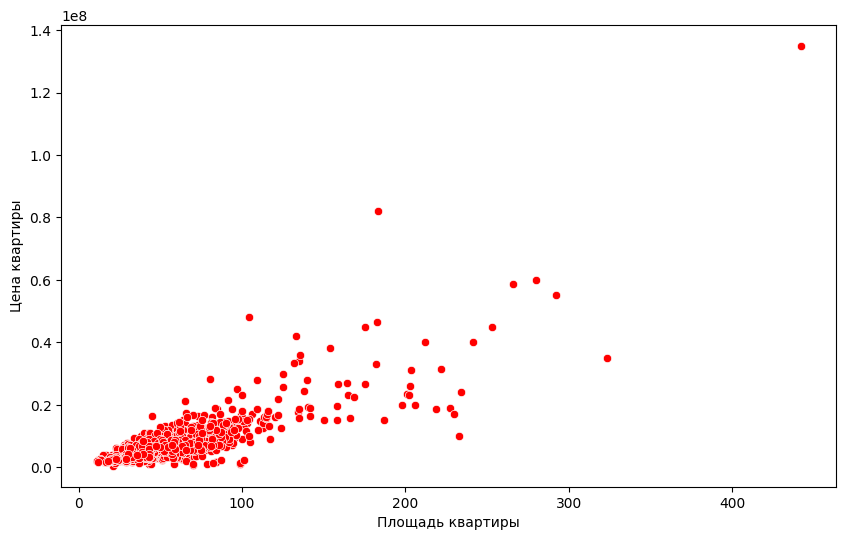

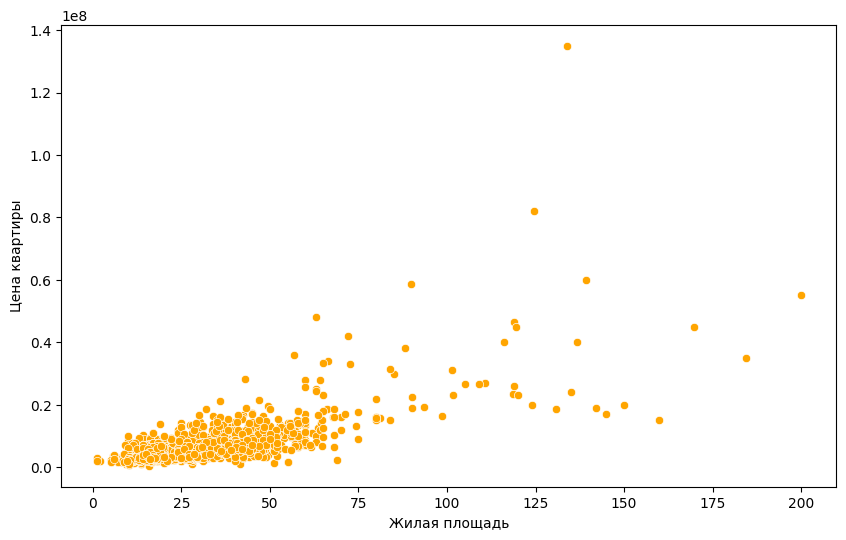

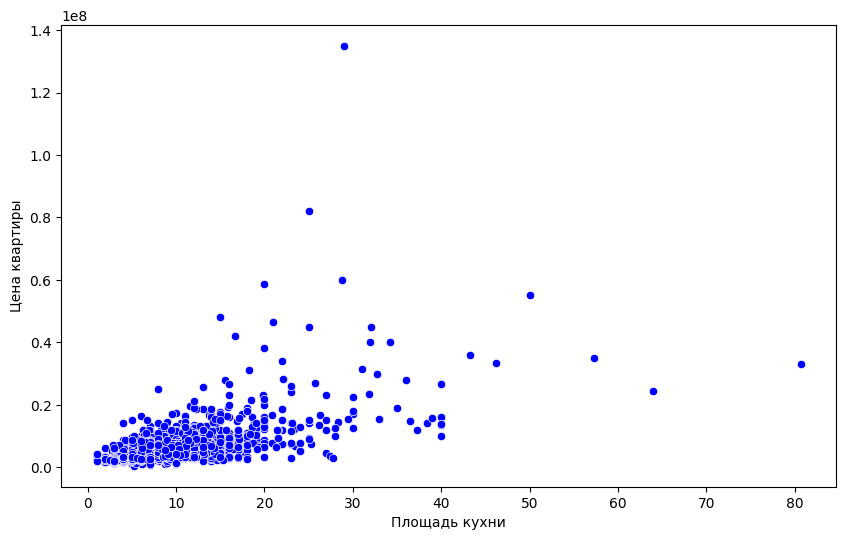

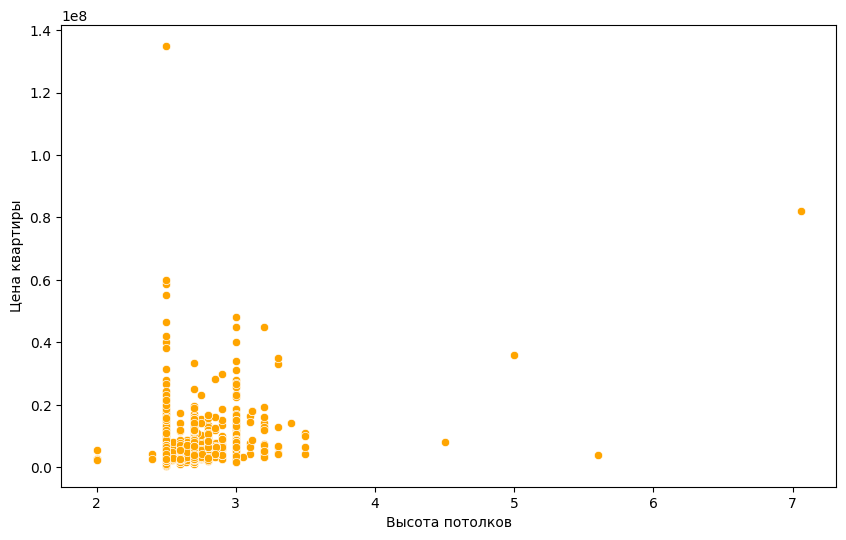

In [22]:
plt.figure(figsize=(10, 6))

plt.xlabel('Площадь квартиры')
plt.ylabel('Цена квартиры')
sns.scatterplot(x=df_dummy['total_square'], y=df_dummy['price'], color='red')

plt.figure(figsize=(10, 6))
plt.xlabel('Жилая площадь')
plt.ylabel('Цена квартиры')
sns.scatterplot(x=df_dummy['living_sq'], y=df_dummy['price'], color='orange')

plt.figure(figsize=(10, 6))
plt.xlabel('Площадь кухни')
plt.ylabel('Цена квартиры')
sns.scatterplot(x=df_dummy['kitchen_sq'], y=df_dummy['price'], color='blue')

plt.figure(figsize=(10, 6))

plt.xlabel('Высота потолков')
plt.ylabel('Цена квартиры')
sns.scatterplot(x=df['ceil_height'], y=df['price'], color='orange')

Теперь взглянем на распределение цен квартир. Для иллюстрации распределения я использовал гистограмму, добавил ядерную оценку плотности. В результате мы можем видеть тяжелый правый хвост и ассимметрию.

<Axes: title={'center': 'Гистограмма цен на квартиры'}, xlabel='Цена квартиры', ylabel='Количество квартир'>

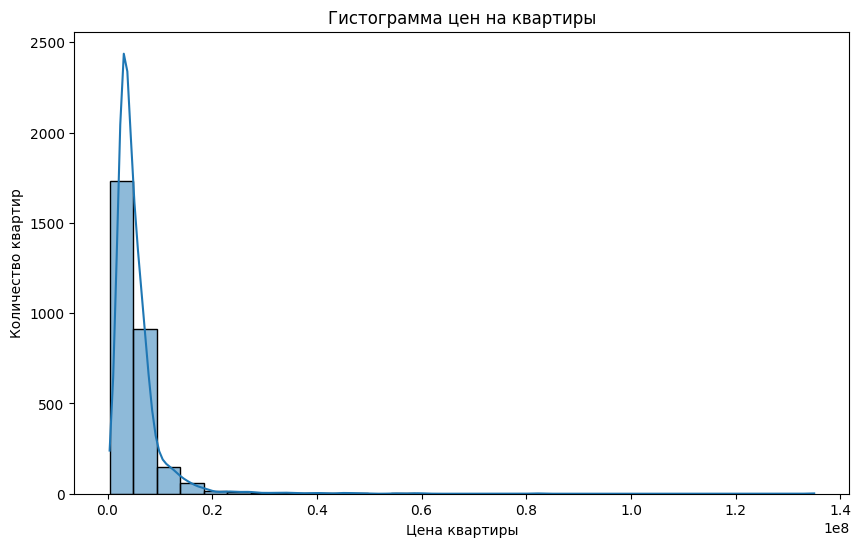

In [68]:
plt.figure(figsize=(10, 6))
plt.xlabel('Цена квартиры')
plt.ylabel('Количество квартир')
plt.title('Гистограмма цен на квартиры')
sns.histplot(df['price'], bins=30, kde=True)

Посмотрим на распределение логарифма цен на квартиры. Оно уже больше напоминает нормальное.

<Axes: title={'center': 'Гистограмма логарифмированных цен на квартиры'}, xlabel='Логарифм цены квартиры', ylabel='Количество квартир'>

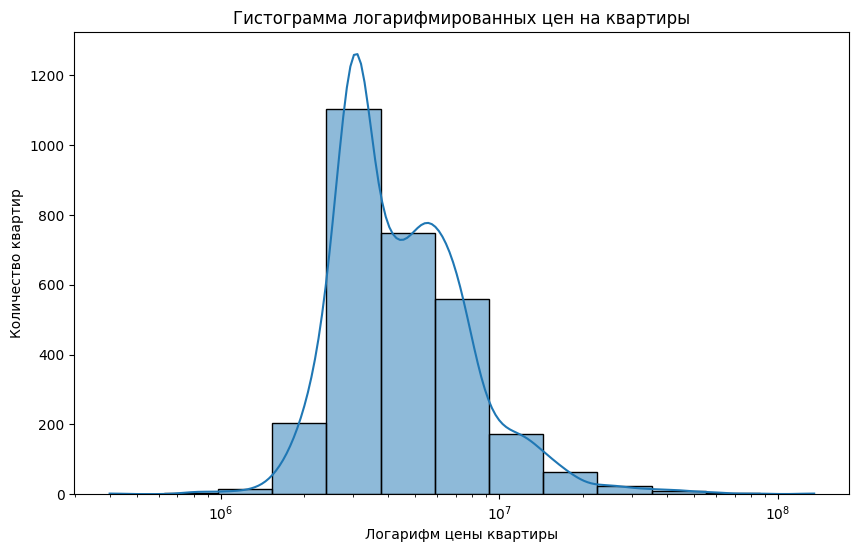

In [69]:
plt.figure(figsize=(10, 6))
plt.xlabel('Логарифм цены квартиры')
plt.ylabel('Количество квартир')
plt.title('Гистограмма логарифмированных цен на квартиры')
sns.histplot(df['price'], bins=(round(1 + 3.322*math.log(len(df), 10))), log_scale=True, kde=True)

Теперь посмотрим на гистограмму площадей квартир. Виден тяжелый правый хвост и ассимметрия. Однако уже можно сказать, что у большей части квартир площадь не превышает 100 квадратных метров.

<Axes: title={'center': 'Гистограмма общей площади квартир'}, xlabel='Общая площадь квартиры', ylabel='Количество квартир'>

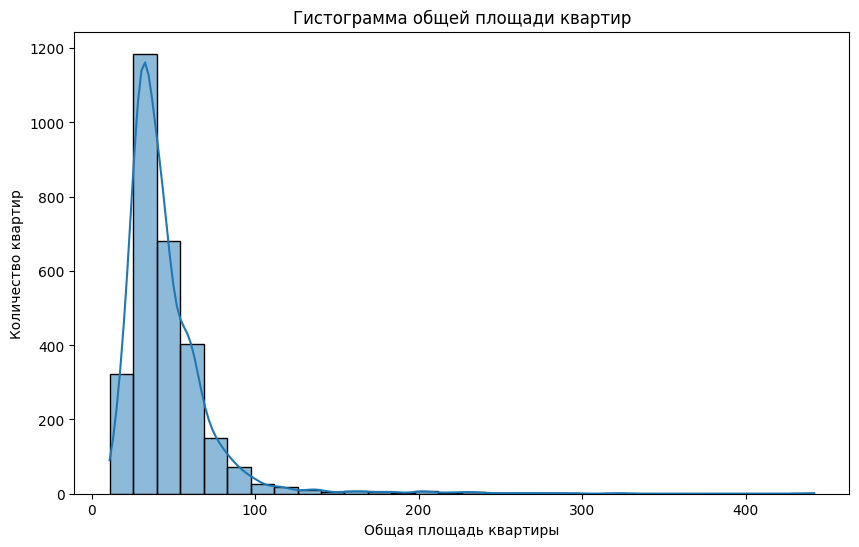

In [70]:
plt.figure(figsize=(10, 6))
plt.title('Гистограмма общей площади квартир')
plt.xlabel('Общая площадь квартиры')
plt.ylabel('Количество квартир')
sns.histplot(df_dummy['total_square'], bins=30, kde=True)

Взглянем на то, как распределено расстояние от квартир до метро в минутах. Большая часть квартир находится примерно в 15 минутах от метро.

<Axes: xlabel='Расстояние до метро (в минутах)', ylabel='Количество квартир'>

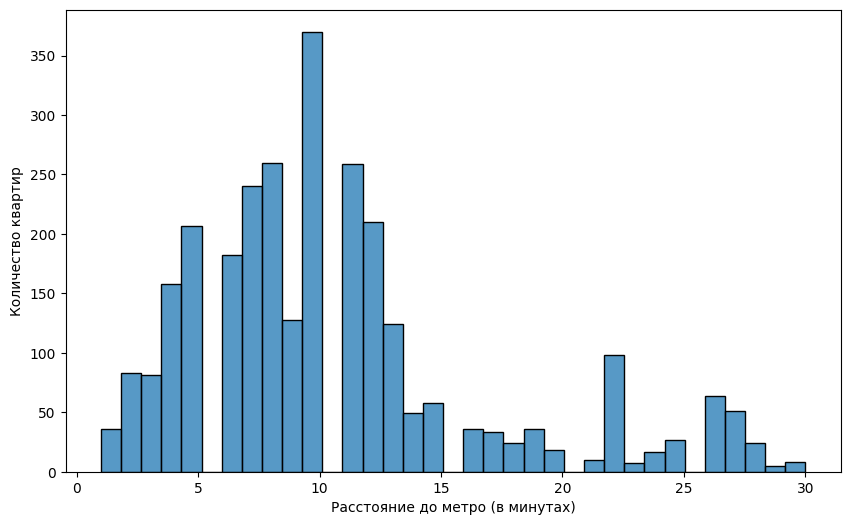

In [71]:
plt.figure(figsize=(10, 6))
plt.xlabel('Расстояние до метро (в минутах)')
plt.ylabel('Количество квартир')
sns.histplot(df['metro'])

In [346]:
df['metro'].describe()

count    2553.000000
mean       10.785742
std         6.176791
min         1.000000
25%         7.000000
50%        10.000000
75%        12.000000
max        30.000000
Name: metro, dtype: float64

Посмотрим на общее соотношение районов в датафрейме. Как можно видеть, меньше всего квартир из Советского района, больше всего - из Ленинского и Кировского.

<Axes: xlabel='Район', ylabel='Количестов квартир'>

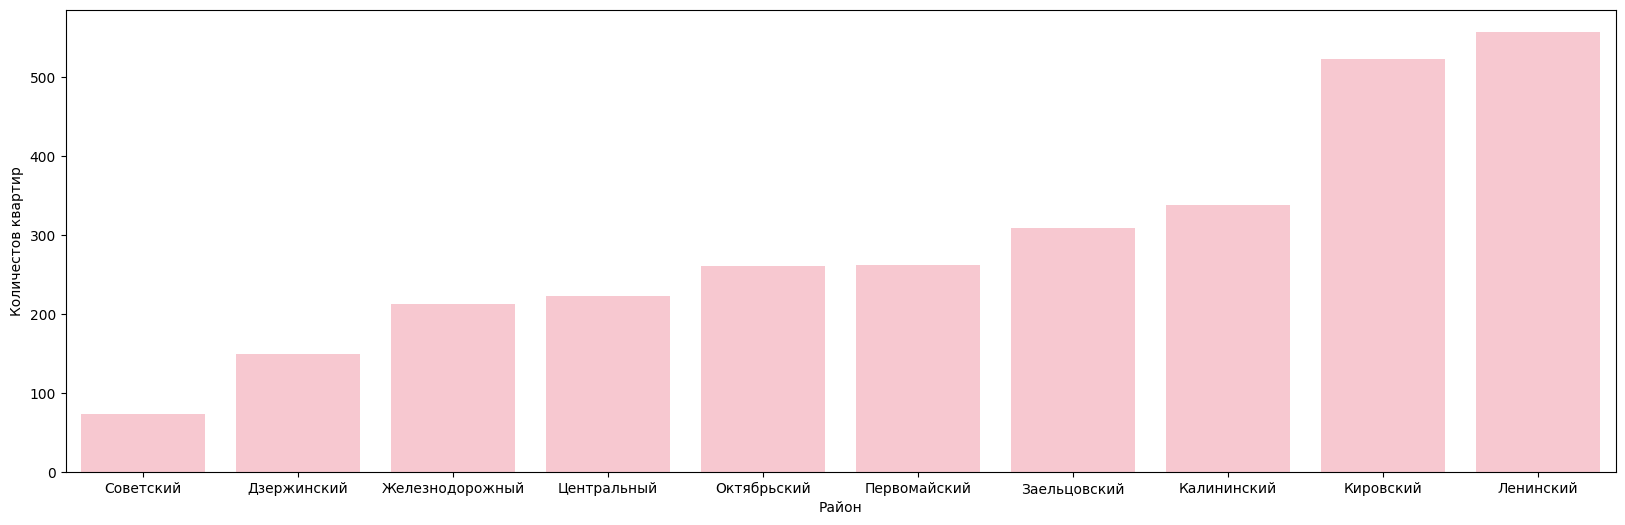

In [72]:
plt.figure(figsize=(20, 6))
plt.ylabel('Количестов квартир')
plt.xlabel('Район')
districts = df['district'].value_counts(ascending=True)
sns.barplot(districts, color='pink')

Пора разобраться с выбросами. Удалять выбросы будем с помощью межквартирльного размаха (IQR). 

In [60]:

for column in['total_square', 'ceil_height', 'kitchen_sq']:
    q1 = df_dummy[column].quantile(0.25)
    q3 = df_dummy[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    df_dummy = df_dummy[df_dummy[column].between(lower_bound, upper_bound)]
    df = df[df[column].between(lower_bound, upper_bound)]
    

Посмотрим на то, как изменилась гистограмма площади квартир. Видно, что правый хвост стал менее тяжелым, нам удалось избавиться от самых явных выбросов.

<Axes: title={'center': 'Гистограмма общей площади квартир'}, xlabel='Общая площадь квартиры', ylabel='Количество квартир'>

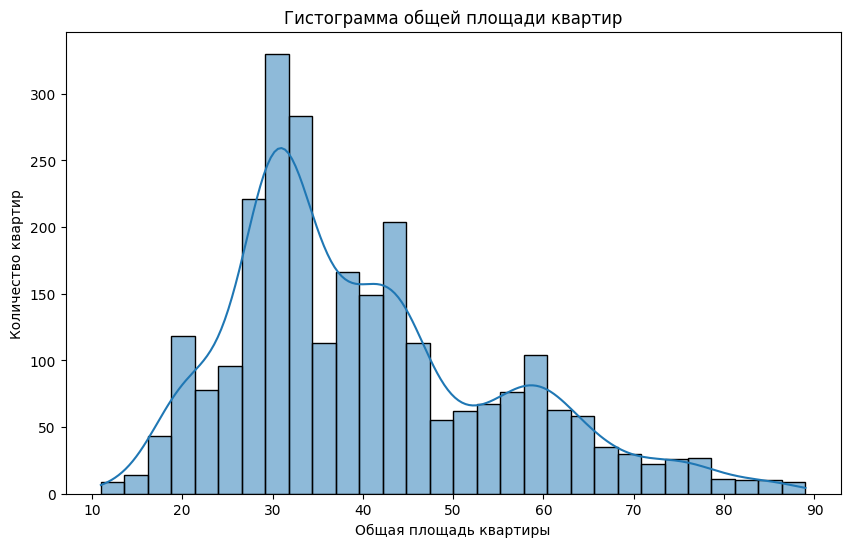

In [74]:
plt.figure(figsize=(10, 6))
plt.title('Гистограмма общей площади квартир')
plt.xlabel('Общая площадь квартиры')
plt.ylabel('Количество квартир')
sns.histplot(df_dummy['total_square'], bins=30, kde=True)

После удаления выбросов также будет полезно взглянуть на то, как изменился точечный график цены квартиры и ее общей площади, площади кухни, жилой площади. К тому же, я решил посмотреть, на то, как зависит цена квартиры от типа дома и расстояния до метро. Сделал это также с помощью точечных графиков. График с типом дома и его ценой оказался не особо информативным. График с метро показал, что все-таки квартиры, расположенные рядом с метро, наверное, стоят в среднем больше чем те, что находятся далеко от метро. Конечно, сказать что-то конкретное можно только после проведения статистических тестов.

<Axes: xlabel='Расстояние до метро (в минутах)', ylabel='Цена квартиры'>

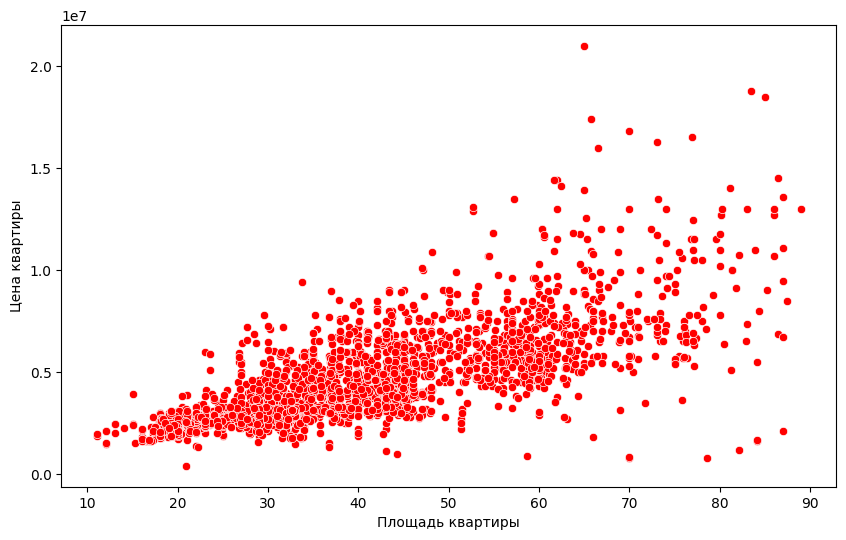

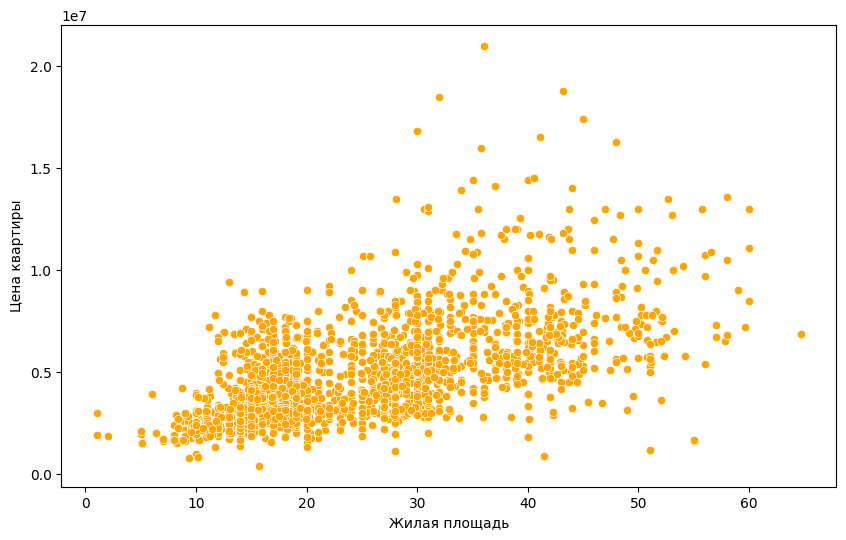

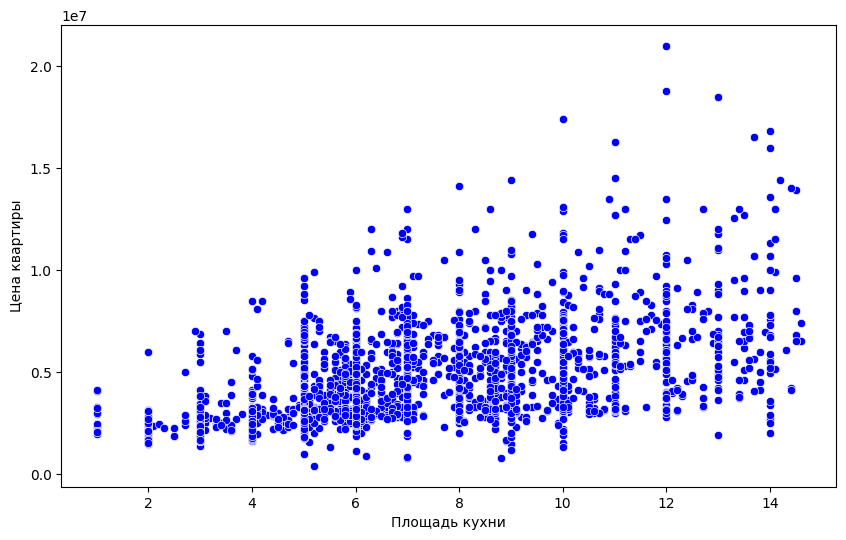

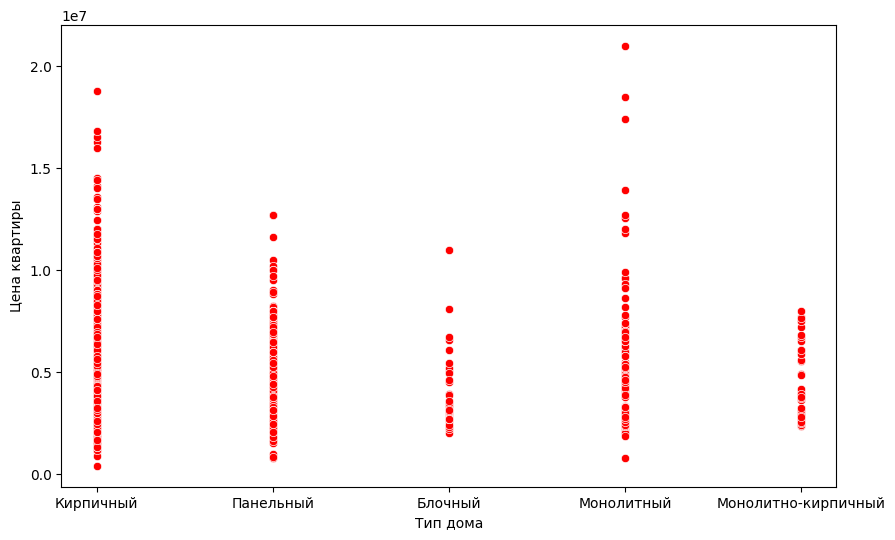

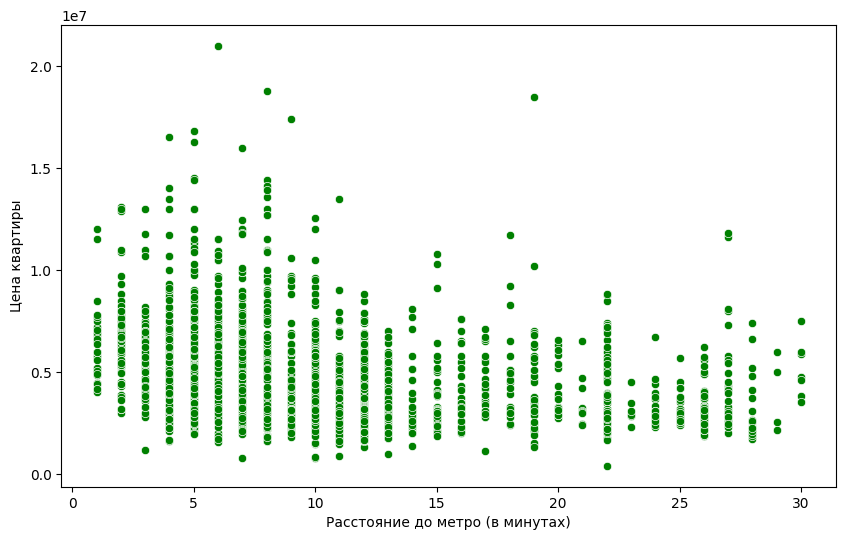

In [75]:
plt.figure(figsize=(10, 6))

plt.xlabel('Площадь квартиры')
plt.ylabel('Цена квартиры')
sns.scatterplot(x=df_dummy['total_square'], y=df_dummy['price'], color='red')

plt.figure(figsize=(10, 6))
plt.xlabel('Жилая площадь')
plt.ylabel('Цена квартиры')
sns.scatterplot(x=df_dummy['living_sq'], y=df_dummy['price'], color='orange')

plt.figure(figsize=(10, 6))
plt.xlabel('Площадь кухни')
plt.ylabel('Цена квартиры')
sns.scatterplot(x=df_dummy['kitchen_sq'], y=df_dummy['price'], color='blue')

plt.figure(figsize=(10, 6))
plt.xlabel('Тип дома')
plt.ylabel('Цена квартиры')
sns.scatterplot(x=df['home_type'], y=df['price'], color='red')

plt.figure(figsize=(10, 6))
plt.xlabel('Расстояние до метро (в минутах)')
plt.ylabel('Цена квартиры')
sns.scatterplot(x=df['metro'], y=df['price'], color='green')

Теперь все-таки посмотрим на корреляционную матрицу числовых признаков. Можем видеть, что цена больше всего коррелирует с общей площадью, жилой площадью и площадью кухни.

<Axes: title={'center': 'Корреляционная матрица числовых признаков'}>

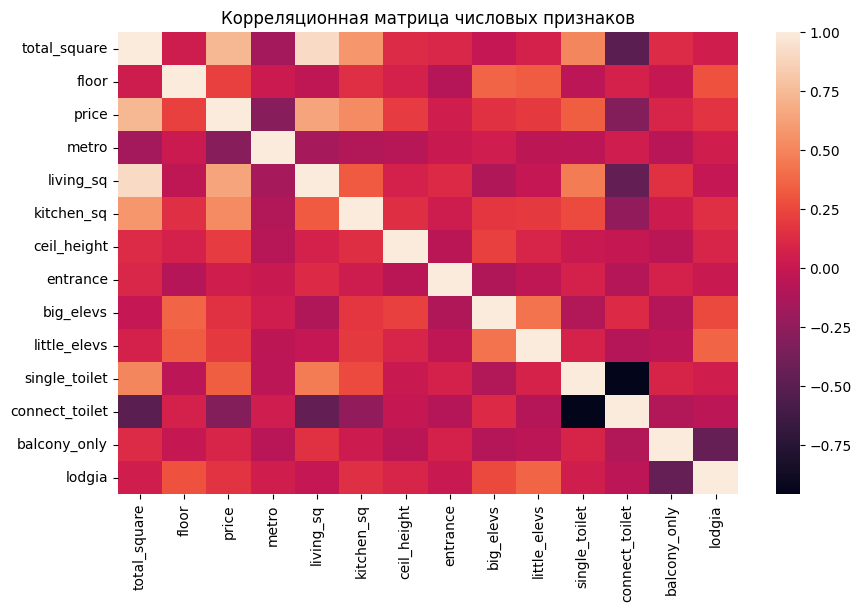

In [76]:
df_numeric = df.select_dtypes(['float64', 'int64'])
plt.figure(figsize=(10, 6))
plt.title('Корреляционная матрица числовых признаков')
sns.heatmap(df_numeric.corr())

Приступим к построению разлчиных моделей и сравнению их эффективности. Для начала разделим выборку на тренировочную и валидационную части. В силу небольшого объема данных, я не стал разделять выборку на тренировочную, тестовую и валидационную части. 

In [68]:
scaler = MinMaxScaler()
columns = df_dummy.columns.to_list()
df_dummy_lr = pd.DataFrame(scaler.fit_transform(df_dummy))
df_dummy_lr.index = df_dummy.index

for column in df_dummy_lr.columns:
    df_dummy_lr[columns[column]] = df_dummy_lr[column]
    df_dummy_lr.drop(column, axis=1, inplace=True)

train_lr, test_lr = train_test_split(df_dummy_lr, test_size=0.2, random_state=34)

Построим линейную регрессию методом наименьших квадратов. На каждой итерации будем удалять незначимый регрессор.

In [69]:
maxpvalue = 1
n = 1
regressors = df_dummy_lr.drop('price', axis=1).columns.to_list()

while maxpvalue > 0.05:
    x = train_lr[regressors]
    y = train_lr['price']
    x1 = sm.add_constant(x)
    model = sm.OLS(y, x1.astype(float)).fit()
    pv = model.pvalues.to_list()
    maxpv = max(pv[1:])
    max_index = pv.index(maxpv)
    print('Номер интерации: '+ str(n))
    print('Регрессор с максимальным p-value: '+ str(regressors[max_index-1]) + ' P-value: '+ str(maxpv))
    print('-------------------------------------------------------------')

    if maxpv > 0.05:
        regressors.pop(max_index - 1)
        maxpvalue = maxpv
        n += 1
    else:
        maxpvalue = 0


Номер интерации: 1
Регрессор с максимальным p-value: district_Советский P-value: 0.9686808689862146
-------------------------------------------------------------
Номер интерации: 2
Регрессор с максимальным p-value: window_view_На улицу и двор P-value: 0.9620166283739298
-------------------------------------------------------------
Номер интерации: 3
Регрессор с максимальным p-value: entrance P-value: 0.86967869977236
-------------------------------------------------------------
Номер интерации: 4
Регрессор с максимальным p-value: window_view_На улицу P-value: 0.7275221180527219
-------------------------------------------------------------
Номер интерации: 5
Регрессор с максимальным p-value: warm_Котел/Квартирное отопление P-value: 0.2999043546070532
-------------------------------------------------------------
Номер интерации: 6
Регрессор с максимальным p-value: warm_Центральное P-value: 0.34299708942553875
-------------------------------------------------------------
Номер интерации: 

Получили модель линейной регрессии. Удивительно, что, оказывается близость к метро, судя по коэффициенту, уменьшает стоимость квартиры. То, как влияет каждый регрессор на стоимость квартиры можно понять, исходя из коэффициента, стоящего перед этим регрессором.

In [70]:
print(model.summary2())

                         Results: Ordinary least squares
Model:                   OLS                   Adj. R-squared:          0.726     
Dependent Variable:      price                 AIC:                     -6082.1815
Date:                    2024-05-07 16:48      BIC:                     -5936.3508
No. Observations:        2016                  Log-Likelihood:          3067.1    
Df Model:                25                    F-statistic:             215.0     
Df Residuals:            1990                  Prob (F-statistic):      0.00      
R-squared:               0.730                 Scale:                   0.0028295 
----------------------------------------------------------------------------------
                                    Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
----------------------------------------------------------------------------------
const                              -0.0501   0.0155 -3.2411 0.0012 -0.0805 -0.0198
total_square                  

Провалидируем нашу модель на тестовом наборе данных.

In [71]:
test_1 = test_lr[model.params.index.to_list()[1:]]
test_1 = sm.add_constant(test_1)
pred = model.predict(test_1)

Можем видеть, что средняя абсолютная ошибка равна 754 тысяч рублей, то есть в среднем модель ошибается на 778 тысяч в определении стоимости квартиры. Учитывая небольшой набор данных, это неплохой показатель, однако все-таки в будущем стоит провалидировать модель на данных, относящихся к разным ценовым категориям.

In [73]:
mean_absolute_percentage_error(test_lr['price'], pred)

0.1853987534067696

In [82]:
test_lr['price'] = pred
df_inversed = scaler.inverse_transform(np.array(test_lr))

Приступим к построению следующей модели - случайного леса (Random forest). Эта модель имеет множество гиперпараметров. Одни из самых важных - количество деревьев в ансамбле (n_estimators), минимальное количество наблюдений в узле дерева для перехода к следующему разделению данных (min_samples_split), максимальная глубина каждого дерева (max_depth). Подбор гиперпараметров осуществим с помощью такого алгоритма как TPESampler (Tree-structured Parzen Estimator). Функция потерь для минимизации - MSE.

In [29]:

df_dummy = pd.get_dummies(df, columns=cat_features, dtype = 'float64')

train, test = train_test_split(df_dummy, test_size=0.2, random_state=42)

def objective_rf(trial):
    X_train, X_val, y_train, y_val = train_test_split(df_dummy.drop(['price'], axis=1), df_dummy['price'], test_size=0.2, random_state=42)

    n_estimators = trial.suggest_int('n_estimators', 10, 100)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    max_depth = trial.suggest_int('max_depth', 5, 10)

    model = RandomForestRegressor(max_depth=max_depth, max_features='sqrt', min_samples_split=min_samples_split, \
                                   n_estimators=n_estimators, random_state=42)
    model.fit(X_train, y_train)
    val_preds = model.predict(X_val)
    mse = mean_squared_error(y_val, val_preds)

    return mse

In [30]:
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler())
study.optimize(objective_rf, n_trials=100)

[I 2024-05-07 11:41:22,753] A new study created in memory with name: no-name-27fab8e7-064e-4a66-b050-09d29b97db42
[I 2024-05-07 11:41:22,875] Trial 0 finished with value: 2010841735134.6843 and parameters: {'n_estimators': 73, 'min_samples_split': 8, 'max_depth': 5}. Best is trial 0 with value: 2010841735134.6843.
[I 2024-05-07 11:41:22,958] Trial 1 finished with value: 1541965417643.2952 and parameters: {'n_estimators': 28, 'min_samples_split': 5, 'max_depth': 9}. Best is trial 1 with value: 1541965417643.2952.
[I 2024-05-07 11:41:23,092] Trial 2 finished with value: 1669375181972.1482 and parameters: {'n_estimators': 59, 'min_samples_split': 8, 'max_depth': 7}. Best is trial 1 with value: 1541965417643.2952.
[I 2024-05-07 11:41:23,284] Trial 3 finished with value: 1478025592667.9697 and parameters: {'n_estimators': 79, 'min_samples_split': 4, 'max_depth': 8}. Best is trial 3 with value: 1478025592667.9697.
[I 2024-05-07 11:41:23,354] Trial 4 finished with value: 1955547227803.6736 an

In [31]:
best_params = study.best_params
best_params

{'n_estimators': 87, 'min_samples_split': 2, 'max_depth': 10}

Подобрав гиперпараметры, обучим модель и провалидируем её. Можем видеть, что ошибка на тестовых данных ниже чем, у линейной регрессии. Однако, говорить об эффективности модели рановато. Проведем перекрестную оценку модели. 

In [32]:
model_rf = RandomForestRegressor(**best_params, max_features='sqrt', random_state=30)
model_rf.fit(train.drop('price', axis=1), train['price'])
pred_rf = model_rf.predict(test.drop('price', axis=1))

mean_absolute_error(pred_rf, test['price'])

703345.6600422146

Можем видеть, что порой абсолютная средняя ошибка оказывается довольно высокой (более 900 тысяч). Однако среднее значение ошибки по итогам кроссвалидации составило 732 тысячи.

In [33]:
cross_val_score(model_rf, df_dummy.drop('price', axis=1), df_dummy['price'], cv=5, scoring='neg_mean_absolute_error')

array([-671544.33179586, -736245.83366712, -707435.27706184,
       -657109.50871132, -674098.89850361])

In [34]:
cross_val_score(model_rf, df_dummy.drop('price', axis=1), df_dummy['price'], cv=5, scoring='neg_mean_absolute_error').mean()

-689286.7699479501

In [35]:
df_compare_rf = pd.DataFrame({'real': test['price'], 'predicted': pred_rf})

Построим модель градиентного бустинга с использованием инструментария библиотеки catboost. Также осуществим подбор гиперпараметров с помощью TPESampler. Среди подбираемых параметров я перебрал количество деревьев в ансамбле (n_estimators), темп обучения (learning_rate), глубину каждого дерева (depth), а также коэффициент L2 регуляризации. В качестве функции потерь для минимизации выбрал MSE.

In [53]:
def objective_gb(trial):
    X_train, X_val, y_train, y_val = train_test_split(df.drop(['price'], axis=1), df_dummy['price'], test_size=0.2, random_state=42)

    n_estimators = trial.suggest_int('n_estimators', 10, 100)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 1)
    depth = trial.suggest_int('depth', 5, 10)
    l2_reg = trial.suggest_float('l2_leaf_reg', 0, 20)

    model = CatBoostRegressor(depth=depth, learning_rate=learning_rate, n_estimators=n_estimators, l2_leaf_reg=l2_reg, cat_features=cat_features)
    model.fit(X_train, y_train)
    val_preds = model.predict(X_val)
    mse = mean_squared_error(y_val, val_preds)

    return mse

In [ ]:
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler())
study.optimize(objective_gb, n_trials=100)

In [51]:
best_params = study.best_params
best_params

{'n_estimators': 94,
 'learning_rate': 0.277523025564519,
 'depth': 6,
 'l2_leaf_reg': 4.080172756418261}

In [52]:
model_gb = CatBoostRegressor(**best_params, random_seed=42)
model_gb.fit(train.drop('price', axis=1), train['price'])

0:	learn: 1934445.2401892	total: 2.06ms	remaining: 192ms
1:	learn: 1724258.9870760	total: 4.23ms	remaining: 194ms
2:	learn: 1562332.7721503	total: 5.54ms	remaining: 168ms
3:	learn: 1454013.2895606	total: 7.54ms	remaining: 170ms
4:	learn: 1370903.0724085	total: 9.22ms	remaining: 164ms
5:	learn: 1304189.0831258	total: 10.9ms	remaining: 160ms
6:	learn: 1239314.7272294	total: 12.4ms	remaining: 155ms
7:	learn: 1180241.7159969	total: 13.7ms	remaining: 148ms
8:	learn: 1144682.0606864	total: 15.1ms	remaining: 142ms
9:	learn: 1107653.5043562	total: 16.3ms	remaining: 137ms
10:	learn: 1084203.2946863	total: 17.5ms	remaining: 132ms
11:	learn: 1064494.9581519	total: 18.7ms	remaining: 128ms
12:	learn: 1044772.9113793	total: 19.9ms	remaining: 124ms
13:	learn: 1027048.9273172	total: 21ms	remaining: 120ms
14:	learn: 1019116.9675246	total: 22.3ms	remaining: 118ms
15:	learn: 1009893.1239569	total: 23.8ms	remaining: 116ms
16:	learn: 994765.6323261	total: 25.3ms	remaining: 115ms
17:	learn: 982253.5772885	t

In [53]:
pred_gb = model_gb.predict(test.drop('price', axis=1))

Провалидируем модель. Как можем видеть, на тестовом наборе данных ошибка снизилась до 600 тысяч. Также проведем перекрестную оценку.

In [54]:
mean_absolute_error(test['price'], pred_gb)

641875.0963463419

In [55]:
compare_df_gb = pd.DataFrame({'real': test['price'], 'predicted': pred_gb})

Перекрестная оценка показала, что средняя ошибка стала еще ниже по сравнению со случайным лесом. 

In [56]:
cross_val_score(model_gb, df_dummy.drop('price', axis=1), df_dummy['price'], cv=5, scoring='neg_mean_absolute_error')

0:	learn: 1969161.6248769	total: 2.05ms	remaining: 191ms
1:	learn: 1742740.7342686	total: 4.02ms	remaining: 185ms
2:	learn: 1577530.8572259	total: 5.65ms	remaining: 171ms
3:	learn: 1456959.4747935	total: 7.55ms	remaining: 170ms
4:	learn: 1356381.7260977	total: 9.71ms	remaining: 173ms
5:	learn: 1290239.9594744	total: 11.2ms	remaining: 164ms
6:	learn: 1242371.1176568	total: 12.8ms	remaining: 159ms
7:	learn: 1191766.6066782	total: 14.4ms	remaining: 155ms
8:	learn: 1159202.9088250	total: 16.1ms	remaining: 152ms
9:	learn: 1132334.4590367	total: 17.6ms	remaining: 148ms
10:	learn: 1109240.2767781	total: 19ms	remaining: 143ms
11:	learn: 1079830.3845435	total: 20.6ms	remaining: 141ms
12:	learn: 1060935.4185829	total: 22.1ms	remaining: 138ms
13:	learn: 1045203.0291182	total: 23.5ms	remaining: 134ms
14:	learn: 1026437.2814246	total: 24.8ms	remaining: 131ms
15:	learn: 1013378.4344676	total: 26.4ms	remaining: 129ms
16:	learn: 1000712.6215278	total: 28ms	remaining: 127ms
17:	learn: 988404.8854074	to

array([-622578.74745794, -667222.79812895, -668441.06040475,
       -626783.44873144, -601575.10305322])

In [57]:
cross_val_score(model_gb, df_dummy.drop('price', axis=1), df_dummy['price'], cv=5, scoring='neg_mean_absolute_error').mean()

0:	learn: 1969161.6248769	total: 1.84ms	remaining: 172ms
1:	learn: 1742740.7342686	total: 3.81ms	remaining: 175ms
2:	learn: 1577530.8572259	total: 5.7ms	remaining: 173ms
3:	learn: 1456959.4747935	total: 7.53ms	remaining: 169ms
4:	learn: 1356381.7260977	total: 9.34ms	remaining: 166ms
5:	learn: 1290239.9594744	total: 10.7ms	remaining: 156ms
6:	learn: 1242371.1176568	total: 11.9ms	remaining: 148ms
7:	learn: 1191766.6066782	total: 13.1ms	remaining: 141ms
8:	learn: 1159202.9088250	total: 14.4ms	remaining: 136ms
9:	learn: 1132334.4590367	total: 15.6ms	remaining: 131ms
10:	learn: 1109240.2767781	total: 16.9ms	remaining: 128ms
11:	learn: 1079830.3845435	total: 18.6ms	remaining: 127ms
12:	learn: 1060935.4185829	total: 20.2ms	remaining: 126ms
13:	learn: 1045203.0291182	total: 22ms	remaining: 125ms
14:	learn: 1026437.2814246	total: 23.5ms	remaining: 124ms
15:	learn: 1013378.4344676	total: 25ms	remaining: 122ms
16:	learn: 1000712.6215278	total: 26.5ms	remaining: 120ms
17:	learn: 988404.8854074	tot

-637320.2315552611

Посмотрим на график значимости каждого признака в модели. Видим, что наиболее значимыми признаками являются: общаю площадь, площадь кухни, близость к метро, этаж, а также жилая площадь.

Text(0.5, 1.0, 'Важность признака')

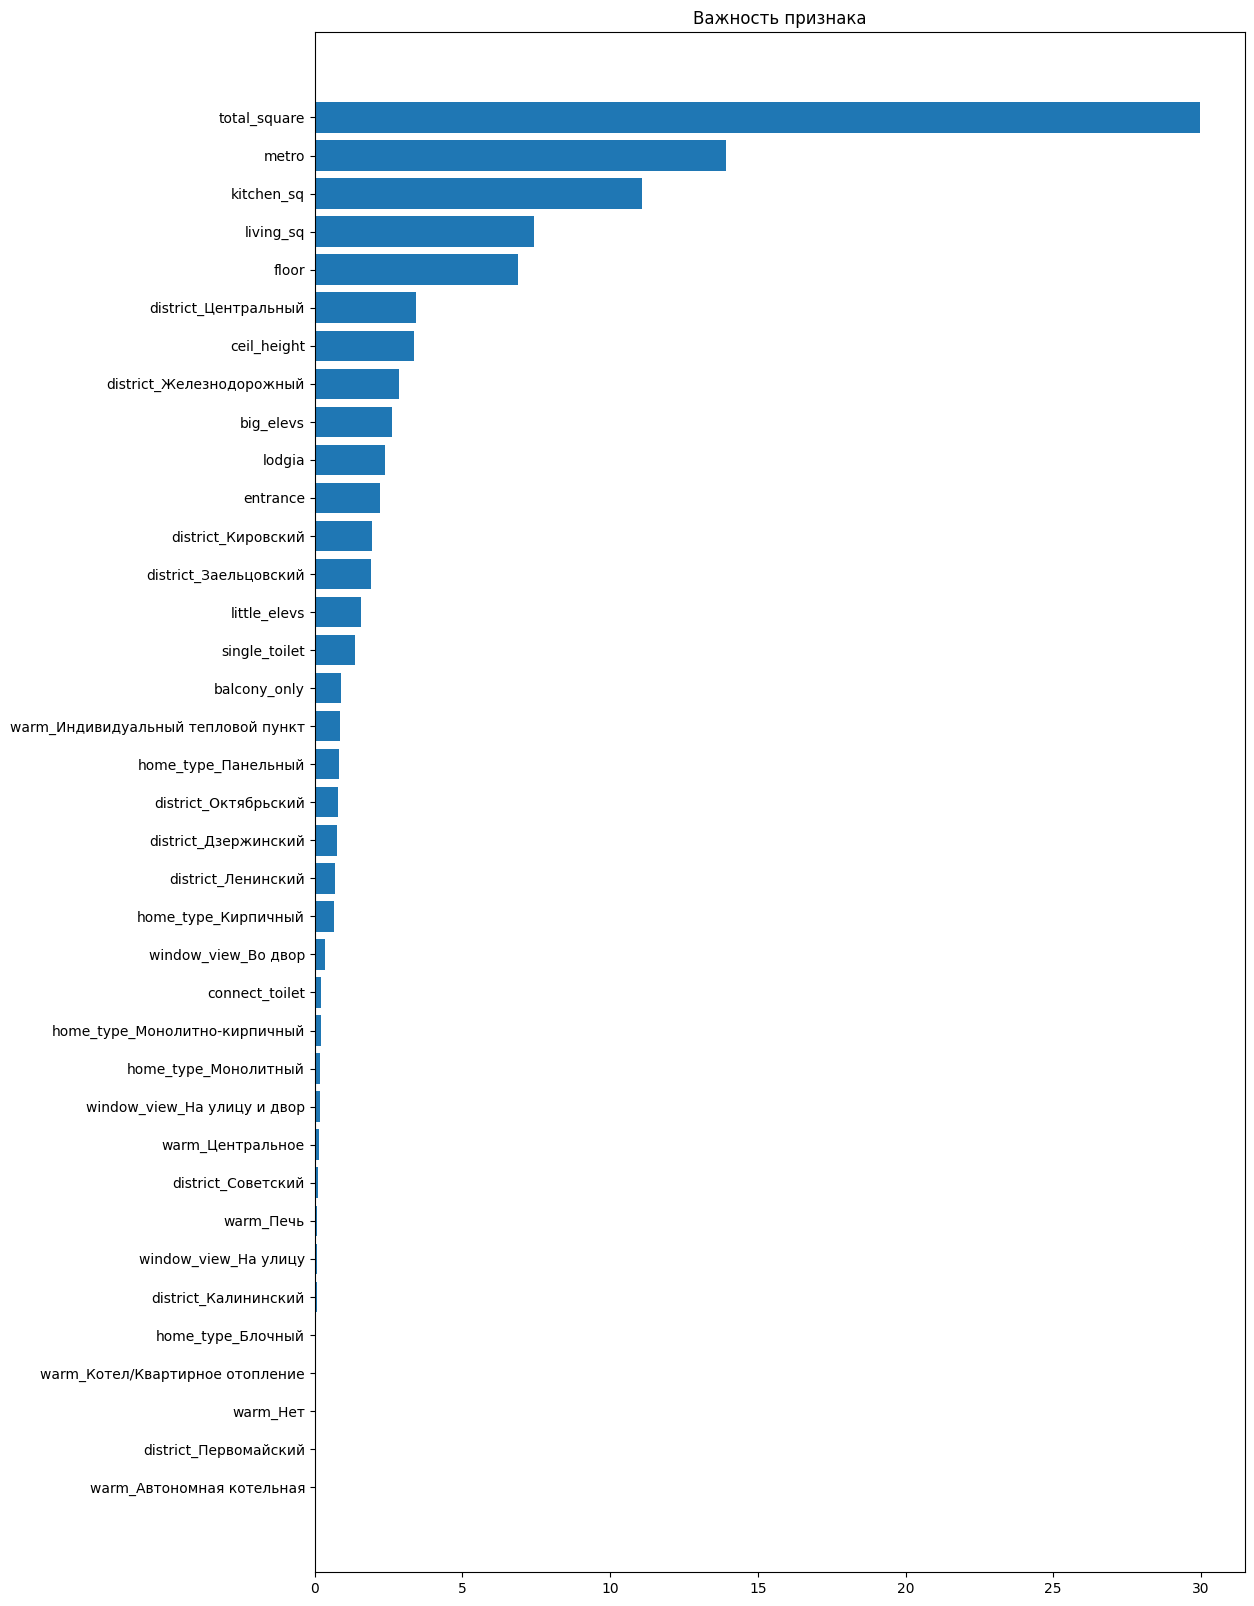

In [58]:
feature_importance = model_gb.feature_importances_
sorted_idx = np.argsort(feature_importance)

fig = plt.figure(figsize=(12, 20))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(test.drop('price', axis=1).columns)[sorted_idx])
plt.title('Важность признака')

Провалидируем модели в разрезе различных ценовых категорий. Помимо линейной регрессии, случайного леса и градиентного бустинга посмотрим на модель гребневой регрессии и лассо регрессии.

In [59]:

groups = [(1000000, 2000000), (2000000, 3000000), (3000000, 4000000), (4000000, 5000000), (5000000, 6000000), (6000000, 7000000), (7000000, float('inf'))]

print('Случайный лес: ')

for group in groups:
    print(f'{group[0]} рублей - {group[1]} рублей')
    predict = model_rf.predict(test[test['price'].between(group[0], group[1])].drop('price', axis=1))
    print(f'MAE: {mean_absolute_error(test[test["price"].between(group[0], group[1])]["price"], predict)}')
    print(f'MAPE: {mean_absolute_percentage_error(test[test["price"].between(group[0], group[1])]["price"], predict) * 100} %')
    print(f'MSE: {mean_squared_error(test[test["price"].between(group[0], group[1])]["price"], predict)}')
    print()


Случайный лес: 
1000000 рублей - 2000000 рублей
MAE: 1027952.2708161359
MAPE: 58.36056102498124 %
MSE: 1305012746982.7966

2000000 рублей - 3000000 рублей
MAE: 425290.51694665395
MAPE: 16.42780897395684 %
MSE: 472592555058.3113

3000000 рублей - 4000000 рублей
MAE: 327294.43813927536
MAPE: 9.690735453628546 %
MSE: 213403853158.5647

4000000 рублей - 5000000 рублей
MAE: 559102.1812980237
MAPE: 12.425331903168042 %
MSE: 547127145519.9484

5000000 рублей - 6000000 рублей
MAE: 723318.7584773755
MAPE: 13.293341154369646 %
MSE: 897521507897.6777

6000000 рублей - 7000000 рублей
MAE: 798044.3891264788
MAPE: 12.238021206515128 %
MSE: 1012611450183.2717

7000000 рублей - inf рублей
MAE: 1663846.8063429433
MAPE: 17.19103365229714 %
MSE: 6026194469212.923



In [60]:
print('Градиентный бустинг: ')

for group in groups:
    print(f'{group[0]} рублей - {group[1]} рублей')
    predict = model_gb.predict(test[test['price'].between(group[0], group[1])].drop('price', axis=1))
    print(f'MAE: {mean_absolute_error(test[test["price"].between(group[0], group[1])]["price"], predict)}')
    print(f'MAPE: {mean_absolute_percentage_error(test[test["price"].between(group[0], group[1])]["price"], predict) * 100} %')
    print(f'MSE: {mean_squared_error(test[test["price"].between(group[0], group[1])]["price"], predict)}')
    print()

Градиентный бустинг: 
1000000 рублей - 2000000 рублей
MAE: 737652.3824516616
MAPE: 42.09676679788548 %
MSE: 800615784298.4868

2000000 рублей - 3000000 рублей
MAE: 370386.4210035492
MAPE: 14.16800451305675 %
MSE: 341639333795.784

3000000 рублей - 4000000 рублей
MAE: 370550.65856386867
MAPE: 11.096147627427532 %
MSE: 261721471842.22675

4000000 рублей - 5000000 рублей
MAE: 536945.3513031261
MAPE: 11.939857269327119 %
MSE: 524567855964.37256

5000000 рублей - 6000000 рублей
MAE: 717259.8866827687
MAPE: 13.06876841698695 %
MSE: 803680051183.7894

6000000 рублей - 7000000 рублей
MAE: 798552.6693490471
MAPE: 12.275141227666229 %
MSE: 1085713765124.539

7000000 рублей - inf рублей
MAE: 1329814.831816036
MAPE: 13.654822922920884 %
MSE: 4593616896410.408



In [39]:
print('Линейная регрессия: ')
model = LinearRegression()
model.fit(train_lr.drop('price', axis=1), train_lr['price'])

for group in groups:
    predict = model.predict(test_lr[test_lr['price'].between(group[0], group[1])].drop('price', axis=1))
    
    print(f'{group[0]} рублей - {group[1]} рублей')
    print(f'MAE: {mean_absolute_error(test_lr[test_lr["price"].between(group[0], group[1])]["price"], predict)}')
    print(f'MAPE: {mean_absolute_percentage_error(test_lr[test_lr["price"].between(group[0], group[1])]["price"], predict) * 100} %')
    print(f'MSE: {mean_squared_error(test_lr[test_lr["price"].between(group[0], group[1])]["price"], predict)}')
    print()

Линейная регрессия: 
1000000 рублей - 2000000 рублей
MAE: 1323774.5523506256
MAPE: 75.54804543439657 %
MSE: 5116841196494.0

2000000 рублей - 3000000 рублей
MAE: 515952.9299826278
MAPE: 19.703630034253646 %
MSE: 436394419690.7811

3000000 рублей - 4000000 рублей
MAE: 594422.1232689552
MAPE: 17.707984302191758 %
MSE: 564487792053.5557

4000000 рублей - 5000000 рублей
MAE: 692557.9814362655
MAPE: 15.697122274664977 %
MSE: 681036685788.2247

5000000 рублей - 6000000 рублей
MAE: 806253.4521275917
MAPE: 14.637849989010135 %
MSE: 992194993075.1858

6000000 рублей - 7000000 рублей
MAE: 828109.5405386242
MAPE: 12.609959480025426 %
MSE: 1031448638109.7645

7000000 рублей - inf рублей
MAE: 1252216.6677338772
MAPE: 13.50040902255842 %
MSE: 2870293166629.2017



In [40]:
print('Гребневая регрессия: ')

model = Ridge(random_state=42)
model.fit(train_lr.drop('price', axis=1), train_lr['price'])

for group in groups:
    predict = model.predict(test_lr[test_lr['price'].between(group[0], group[1])].drop('price', axis=1))
    
    print(f'{group[0]} рублей - {group[1]} рублей')
    print(f'MAE: {mean_absolute_error(test_lr[test_lr["price"].between(group[0], group[1])]["price"], predict)}')
    print(f'MAPE: {mean_absolute_percentage_error(test_lr[test_lr["price"].between(group[0], group[1])]["price"], predict) * 100} %')
    print(f'MSE: {mean_squared_error(test_lr[test_lr["price"].between(group[0], group[1])]["price"], predict)}')
    print()


Гребневая регрессия: 
1000000 рублей - 2000000 рублей
MAE: 1377797.0700593565
MAPE: 78.661144810233 %
MSE: 5149097284844.328

2000000 рублей - 3000000 рублей
MAE: 510629.55067782826
MAPE: 19.4844300974842 %
MSE: 424111420769.687

3000000 рублей - 4000000 рублей
MAE: 594104.2482341897
MAPE: 17.705270144194 %
MSE: 563417085447.5526

4000000 рублей - 5000000 рублей
MAE: 688823.0487474358
MAPE: 15.622581236664345 %
MSE: 679630051830.721

5000000 рублей - 6000000 рублей
MAE: 799888.5810614445
MAPE: 14.510464217367675 %
MSE: 970083682643.0411

6000000 рублей - 7000000 рублей
MAE: 813604.374427599
MAPE: 12.397278738437734 %
MSE: 1002366392459.8164

7000000 рублей - inf рублей
MAE: 1242762.1156927685
MAPE: 13.347662087222234 %
MSE: 2838123979215.6826



In [41]:
print('Лассо регрессия: ')

model = Lasso(random_state=42)
model.fit(train_lr.drop('price', axis=1), train_lr['price'])

for group in groups:
    predict = model.predict(test_lr[test_lr['price'].between(group[0], group[1])].drop('price', axis=1))
    
    print(f'{group[0]} рублей - {group[1]} рублей')
    print(f'MAE: {mean_absolute_error(test_lr[test_lr["price"].between(group[0], group[1])]["price"], predict)}')
    print(f'MAPE: {mean_absolute_percentage_error(test_lr[test_lr["price"].between(group[0], group[1])]["price"], predict) * 100} %')
    print(f'MSE: {mean_squared_error(test_lr[test_lr["price"].between(group[0], group[1])]["price"], predict)}')
    print()


Лассо регрессия: 
1000000 рублей - 2000000 рублей
MAE: 1323784.213452895
MAPE: 75.54773313258418 %
MSE: 5116871908843.448

2000000 рублей - 3000000 рублей
MAE: 515939.11310784414
MAPE: 19.70308694618096 %
MSE: 436355915588.5487

3000000 рублей - 4000000 рублей
MAE: 594415.7447500215
MAPE: 17.70778664334492 %
MSE: 564477284740.7908

4000000 рублей - 5000000 рублей
MAE: 692546.5605985632
MAPE: 15.69688230599959 %
MSE: 681017885487.1345

5000000 рублей - 6000000 рублей
MAE: 806235.4472925704
MAPE: 14.637513881982967 %
MSE: 992159442961.3597

6000000 рублей - 7000000 рублей
MAE: 828096.584048616
MAPE: 12.609761490248847 %
MSE: 1031418107131.2289

7000000 рублей - inf рублей
MAE: 1252211.6875851036
MAPE: 13.500344677130688 %
MSE: 2870275682313.5854



Можем видеть, что все модели плохо предсказывают цену "дешевых" квартир. В диапазоне от 3 миллионов до 5 миллионов лучше всех себя показывает градиентный бустинг, а цену "дорогих" квартир все модели предсказывают не очень хорошо, но значения ошибок не сильно различаются у моделей. Можно сделать вывод, что необходимо дополнить выборку квартирами с низкой ценой и высокой ценой, чтобы улучшить метрики качества моделей.